In [322]:
import numpy as np 
from matplotlib import pyplot as plt
import pandas 
import math

In [323]:
def distance(a, b):
    return math.sqrt(np.sum(np.square(np.array(a) - np.array(b))))

def midpoint(a, b, c, d):
    return ((a+ c)/2, (b + d)/2)


Some constants are defined below: 

In [324]:
DATA_PATH = "data/New/"

DISCARD_AMOUNT = [2400, 2450, 0, 0, 0, 0, 0, 2550]
CASE_NAMES = ["90", "180", ">90 1", ">90 2", ">90 3", "<90 1", "<90 2", "<90 3"]

# 10g
MASS = 10

Visualizing the entire path of tracked points. It is not possible to process data as is, and data must processed to exclude to only have few frames before and after the point of contact. 

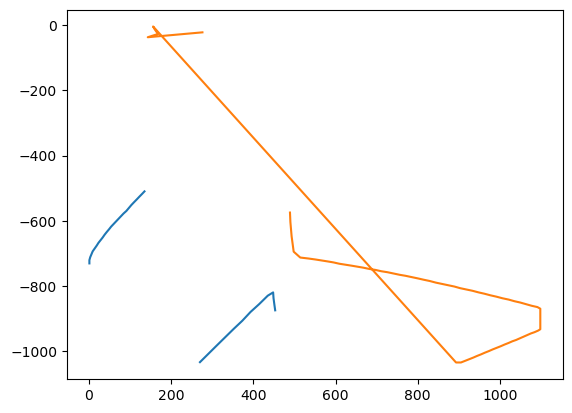

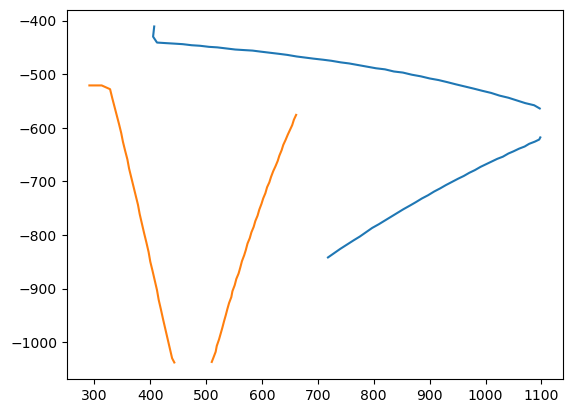

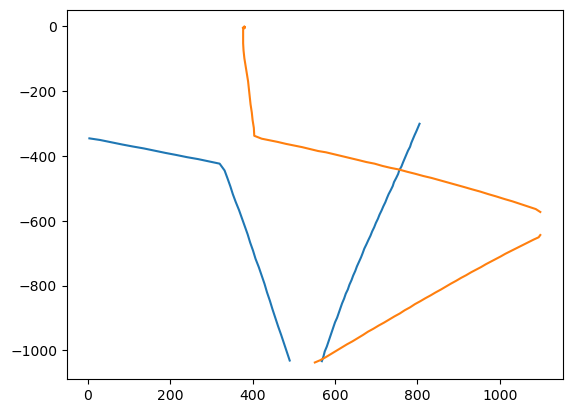

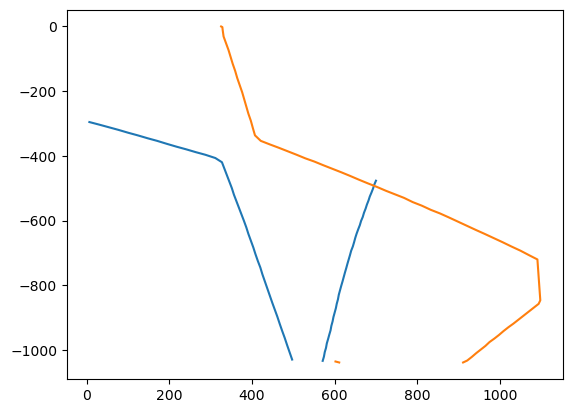

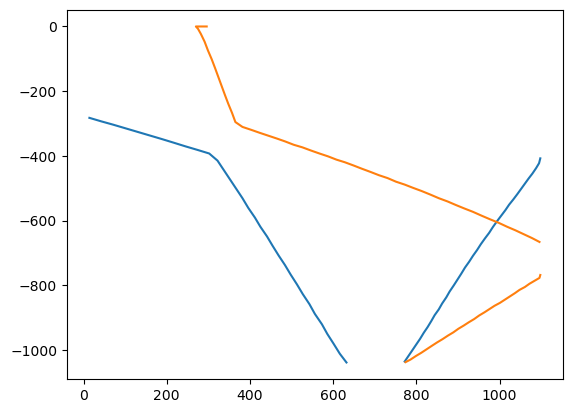

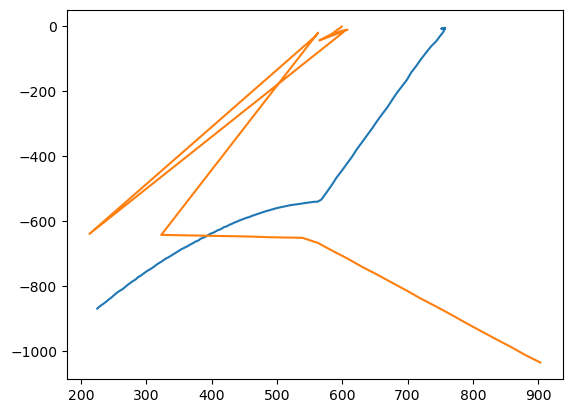

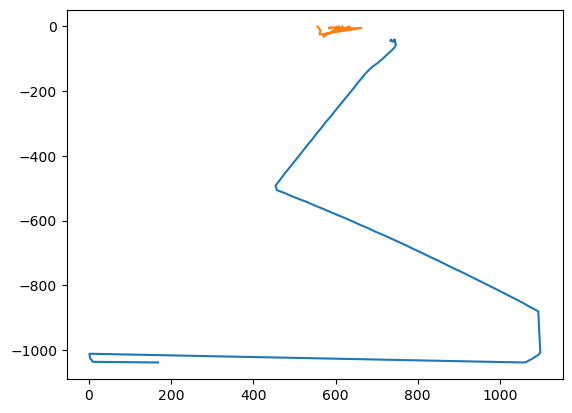

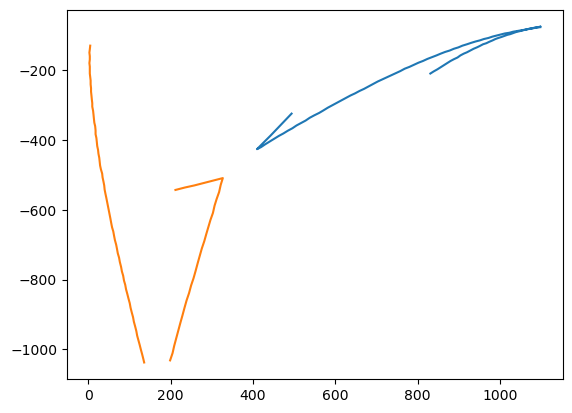

In [325]:
for i in range(1, 9):
    data = pandas.read_csv(DATA_PATH + "{}.csv".format(i))
    data = data[data["timestamp"] > DISCARD_AMOUNT[i-1]]      

    plt.plot(data["position_px_x-hotpink"], -1 * data["position_px_y-hotpink"])    
    plt.plot(data["position_px_x-lightorange"], -1 * data["position_px_y-lightorange"])          
    plt.show()

Here few things are being done: the loop looks for the time when two tracking points comes the closest. That will be the time when two disks collide. Some predetermined data was used to discard first few frames to make it more accurate(it is using `DISCARD_AMOUNT`). When subset of tracking data before and after 300 micro-second is determined, that data can be splitted into tracking data before and after the collision.

To make plot a bit more interesting, a green point, representing the midpoint between the point of contact, was added to to the plots.

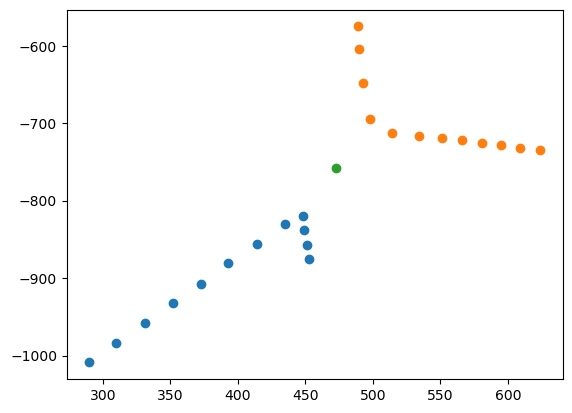

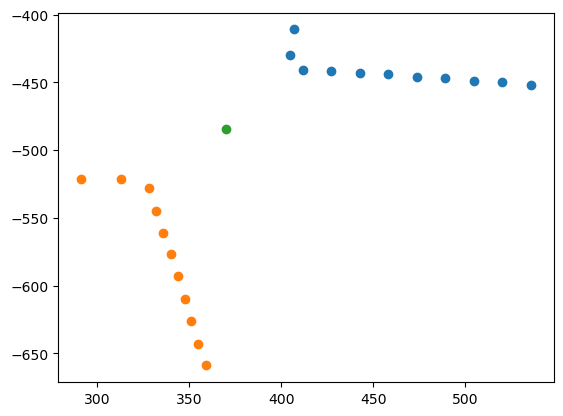

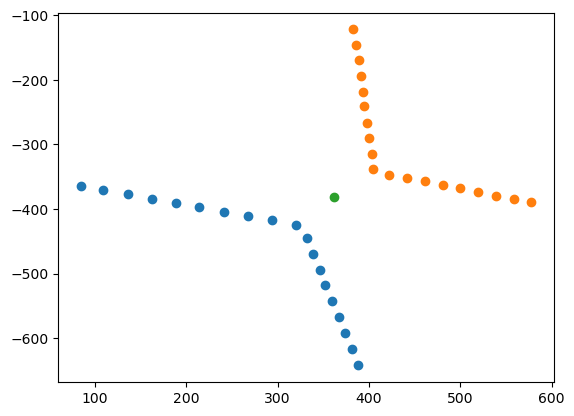

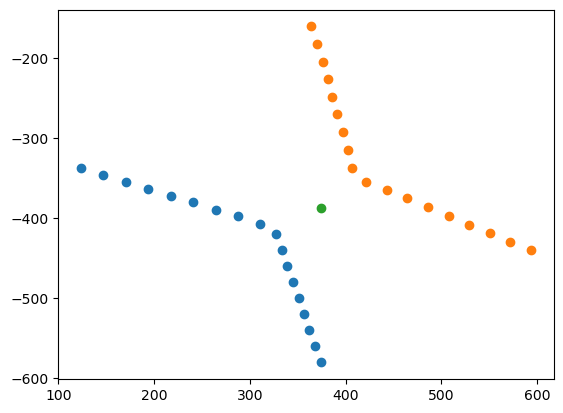

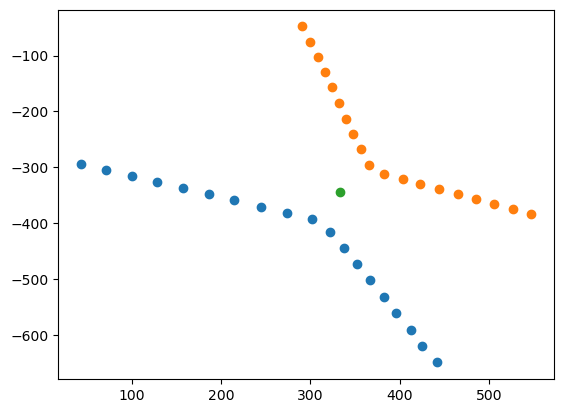

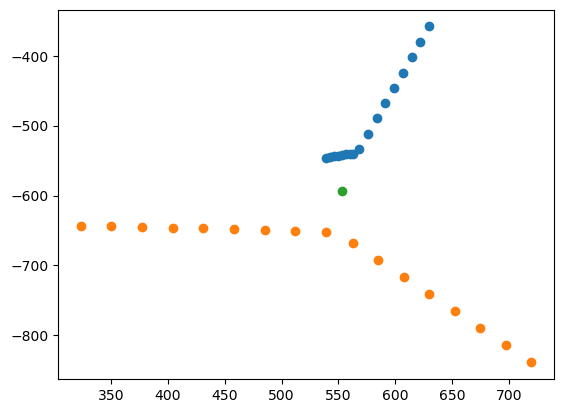

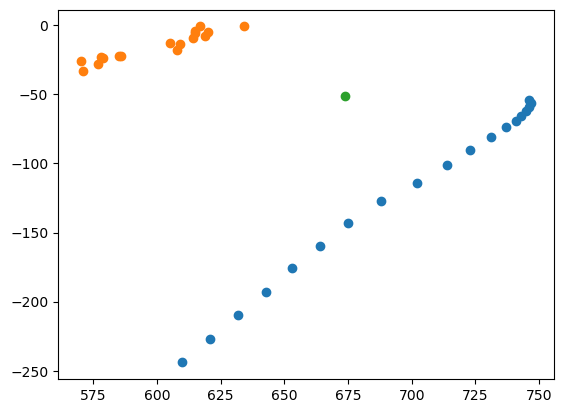

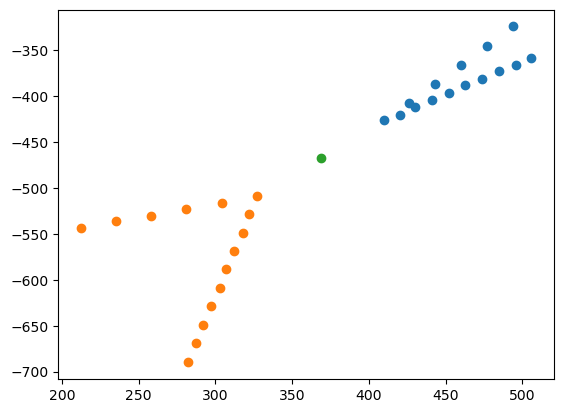

In [326]:
aroundContacts = []

for i in range(1, 9):
    data = pandas.read_csv(DATA_PATH + "{}.csv".format(i)) 
    data = data[data["timestamp"] > DISCARD_AMOUNT[i-1]]      

    minDist = 100000
    mintime = 0
    for _, row in data.iterrows():      
        time = row["timestamp"]
        pink_x = row["position_px_x-hotpink"]
        pink_y = row["position_px_y-hotpink"]      
        pink_vx = row["vx-hotpink"]
        pink_vy = row["vy-hotpink"]
        orange_x = row["position_px_x-lightorange"]
        orange_y = row["position_px_y-lightorange"]              
        orange_vx = row["vx-lightorange"]
        orange_vy = row["vy-lightorange"]  

        if distance([pink_x, pink_y], [orange_x, orange_y]) < minDist:
            mintime = time
            minDist = distance([pink_x, pink_y], [orange_x, orange_y])            
    
    aroundContact = data[abs(data['timestamp'] - mintime) < 300]

    beforeContact = aroundContact[aroundContact['timestamp'] < mintime]
    afterContact = aroundContact[aroundContact['timestamp'] >= mintime]         

    plt.scatter(aroundContact["position_px_x-hotpink"], -1 * aroundContact["position_px_y-hotpink"])    
    plt.scatter(aroundContact["position_px_x-lightorange"], -1 * aroundContact["position_px_y-lightorange"])          

    mid = aroundContact[aroundContact['timestamp'] == mintime]
    midx, midy = midpoint(mid["position_px_x-hotpink"], mid["position_px_y-hotpink"], mid["position_px_x-lightorange"], mid["position_px_y-lightorange"])
    plt.scatter(midx, -midy)
    plt.show()

    aroundContacts.append((beforeContact, afterContact))

From data point before and after the contact, momentum and kinetic energy can be calculated along with their uncertainty. The velocity value give by the tracking script was largely inaccurate, so velocity data are recalculated using the position and time data. 

In [327]:
def findUncertainty(x):
    return np.average(x), np.std(x)/math.sqrt(len(x))

def removeNan(x):
    return x[~np.isnan(x)]

def magnitude(x):
    return math.sqrt(np.sum(np.square(x)))
        
result = []

for d in aroundContacts:
    before_, after_ = d
    before = before_.copy()
    after = after_.copy()

    out = {}

    dist = before.diff().fillna(0.)
    before["vx-hotpink"] = dist["position_px_x-hotpink"] / dist["timestamp"]
    before["vy-hotpink"] = dist["position_px_y-hotpink"] / dist["timestamp"]
    before["vx-lightorange"] = dist["position_px_x-lightorange"] / dist["timestamp"]  
    before["vy-lightorange"] = dist["position_px_y-lightorange"] / dist["timestamp"]  

    dist2 = after.copy().diff().fillna(0.)
    after["vx-hotpink"] = dist2["position_px_x-hotpink"] / dist2["timestamp"]
    after["vy-hotpink"] = dist2["position_px_y-hotpink"] / dist2["timestamp"]    
    after["vx-lightorange"] = dist2["position_px_x-lightorange"] / dist2["timestamp"]  
    after["vy-lightorange"] = dist2["position_px_y-lightorange"] / dist2["timestamp"]     

    vecPink = [np.sum(dist["position_px_x-hotpink"]), np.sum(dist["position_px_y-hotpink"])]
    vecOrange = [np.sum(dist["position_px_x-lightorange"]), np.sum(dist["position_px_y-lightorange"])]
    out["beforeAngle"] = np.degrees(np.arccos(np.dot(vecPink, vecOrange) / (magnitude(vecPink) * magnitude(vecOrange))))

    vecPink = [np.sum(dist2["position_px_x-hotpink"]), np.sum(dist2["position_px_y-hotpink"])]
    vecOrange = [np.sum(dist2["position_px_x-lightorange"]), np.sum(dist2["position_px_y-lightorange"])]
    out["afterAngle"] = np.degrees(np.arccos(np.dot(vecPink, vecOrange) / (magnitude(vecPink) * magnitude(vecOrange))))
    
    beforePinkPX, beforePinkPXUncert = findUncertainty(removeNan(np.array(before["vx-hotpink"])) * MASS)
    beforePinkPY, beforePinkPYUncert = findUncertainty(removeNan(np.array(before["vy-hotpink"])) * MASS)
    beforeOrangePX, beforeOrangePXUncert = findUncertainty(removeNan(np.array(before["vx-lightorange"])) * MASS)
    beforeOrangePY, beforeOrangePYUncert = findUncertainty(removeNan(np.array(before["vy-lightorange"])) * MASS)    

    afterPinkPX, afterPinkPXUncert = findUncertainty(removeNan(np.array(after["vx-hotpink"])) * MASS)
    afterPinkPY, afterPinkPYUncert = findUncertainty(removeNan(np.array(after["vy-hotpink"])) * MASS)
    afterOrangePX, afterOrangePXUncert = findUncertainty(removeNan(np.array(after["vx-lightorange"])) * MASS)
    afterOrangePY, afterOrangePYUncert = findUncertainty(removeNan(np.array(after["vy-lightorange"])) * MASS)

    totalBeforePX, totalBeforePXUncert = beforePinkPX + beforeOrangePX, math.sqrt(beforePinkPXUncert **2 + beforeOrangePXUncert **2)
    totalAfterPX, totalAfterPXUncert = afterPinkPX + afterOrangePX, math.sqrt(afterPinkPXUncert **2 + afterOrangePXUncert **2)

    totalBeforePY, totalBeforePYUncert = beforePinkPY + beforeOrangePY, math.sqrt(beforePinkPYUncert **2 + beforeOrangePYUncert **2)
    totalAfterPY, totalAfterPYUncert = afterPinkPY + afterOrangePY, math.sqrt(afterPinkPYUncert **2 + afterOrangePYUncert **2)

    beforeOverAfterX, beforeOverAfterXUncert = totalBeforePX / totalAfterPX, math.sqrt(totalBeforePXUncert**2 + totalAfterPXUncert**2)
    beforeOverAfterY, beforeOverAfterYUncert = totalBeforePY / totalAfterPY, math.sqrt(totalBeforePYUncert**2 + totalAfterPYUncert**2)       

    out["beforePinkPX"] = beforePinkPX
    out["beforePinkPXUncert"] = beforePinkPXUncert
    out["beforePinkPY"] = beforePinkPY
    out["beforePinkPYUncert"] = beforePinkPYUncert    
    out["beforeOrangePX"] = beforeOrangePX
    out["beforeOrangePXUncert"] = beforeOrangePXUncert
    out["beforeOrangePY"] = beforeOrangePY
    out["beforeOrangePYUncert"] = beforeOrangePYUncert

    out["afterPinkPX"] = afterPinkPX
    out["afterPinkPXUncert"] = afterPinkPXUncert
    out["afterPinkPY"] = afterPinkPY
    out["afterPinkPYUncert"] = afterPinkPYUncert    
    out["afterOrangePX"] = afterOrangePX
    out["afterOrangePXUncert"] = afterOrangePXUncert
    out["afterOrangePY"] = afterOrangePY
    out["afterOrangePYUncert"] = afterOrangePYUncert            

    out["totalBeforePX"] = totalBeforePX
    out["totalBeforePXUncert"] = totalBeforePXUncert
    out["totalBeforePY"] = totalBeforePY
    out["totalBeforePYUncert"] = totalBeforePYUncert    

    out["totalAfterPX"] = totalAfterPX
    out["totalAfterPXUncert"] = totalAfterPXUncert
    out["totalAfterPY"] = totalAfterPY
    out["totalAfterPYUncert"] = totalAfterPYUncert   

    out["beforeOverAfterX"] = beforeOverAfterX
    out["beforeOverAfterXUncert"] = beforeOverAfterXUncert     
    out["beforeOverAfterY"] = beforeOverAfterY
    out["beforeOverAfterYUncert"] = beforeOverAfterYUncert   

    out["beforePinkK"], out["beforePinkKUncert"] = findUncertainty(removeNan((1/2) * MASS * (np.array(before["vx-hotpink"]) ** 2 + np.array(before["vy-hotpink"]) ** 2)))
    out["beforeOrangeK"], out["beforeOrangeKUncert"] = findUncertainty(removeNan((1/2) * MASS * (np.array(before["vx-lightorange"]) ** 2 + np.array(before["vy-lightorange"]) ** 2)))    

    out["afterPinkK"], out["afterPinkKUncert"] = findUncertainty(removeNan((1/2) * MASS * (np.array(after["vx-hotpink"]) ** 2 + np.array(after["vy-hotpink"]) ** 2)))
    out["afterOrangeK"], out["afterOrangeKUncert"] = findUncertainty(removeNan((1/2) * MASS * (np.array(after["vx-lightorange"]) ** 2 + np.array(after["vy-lightorange"]) ** 2)))        

    out["beforeTotalK"] = out["beforePinkK"] + out["beforeOrangeK"]
    out["beforeTotalKUncert"] = math.sqrt(out["beforePinkKUncert"]**2 + out["beforeOrangeKUncert"]**2)

    out["afterTotalK"] = out["afterPinkK"] + out["afterOrangeK"]
    out["afterTotalKUncert"] = math.sqrt(out["afterPinkKUncert"]**2 + out["afterOrangeKUncert"]**2)    
    

    result.append(out)      


Following plots what's found from previous calculations.

()

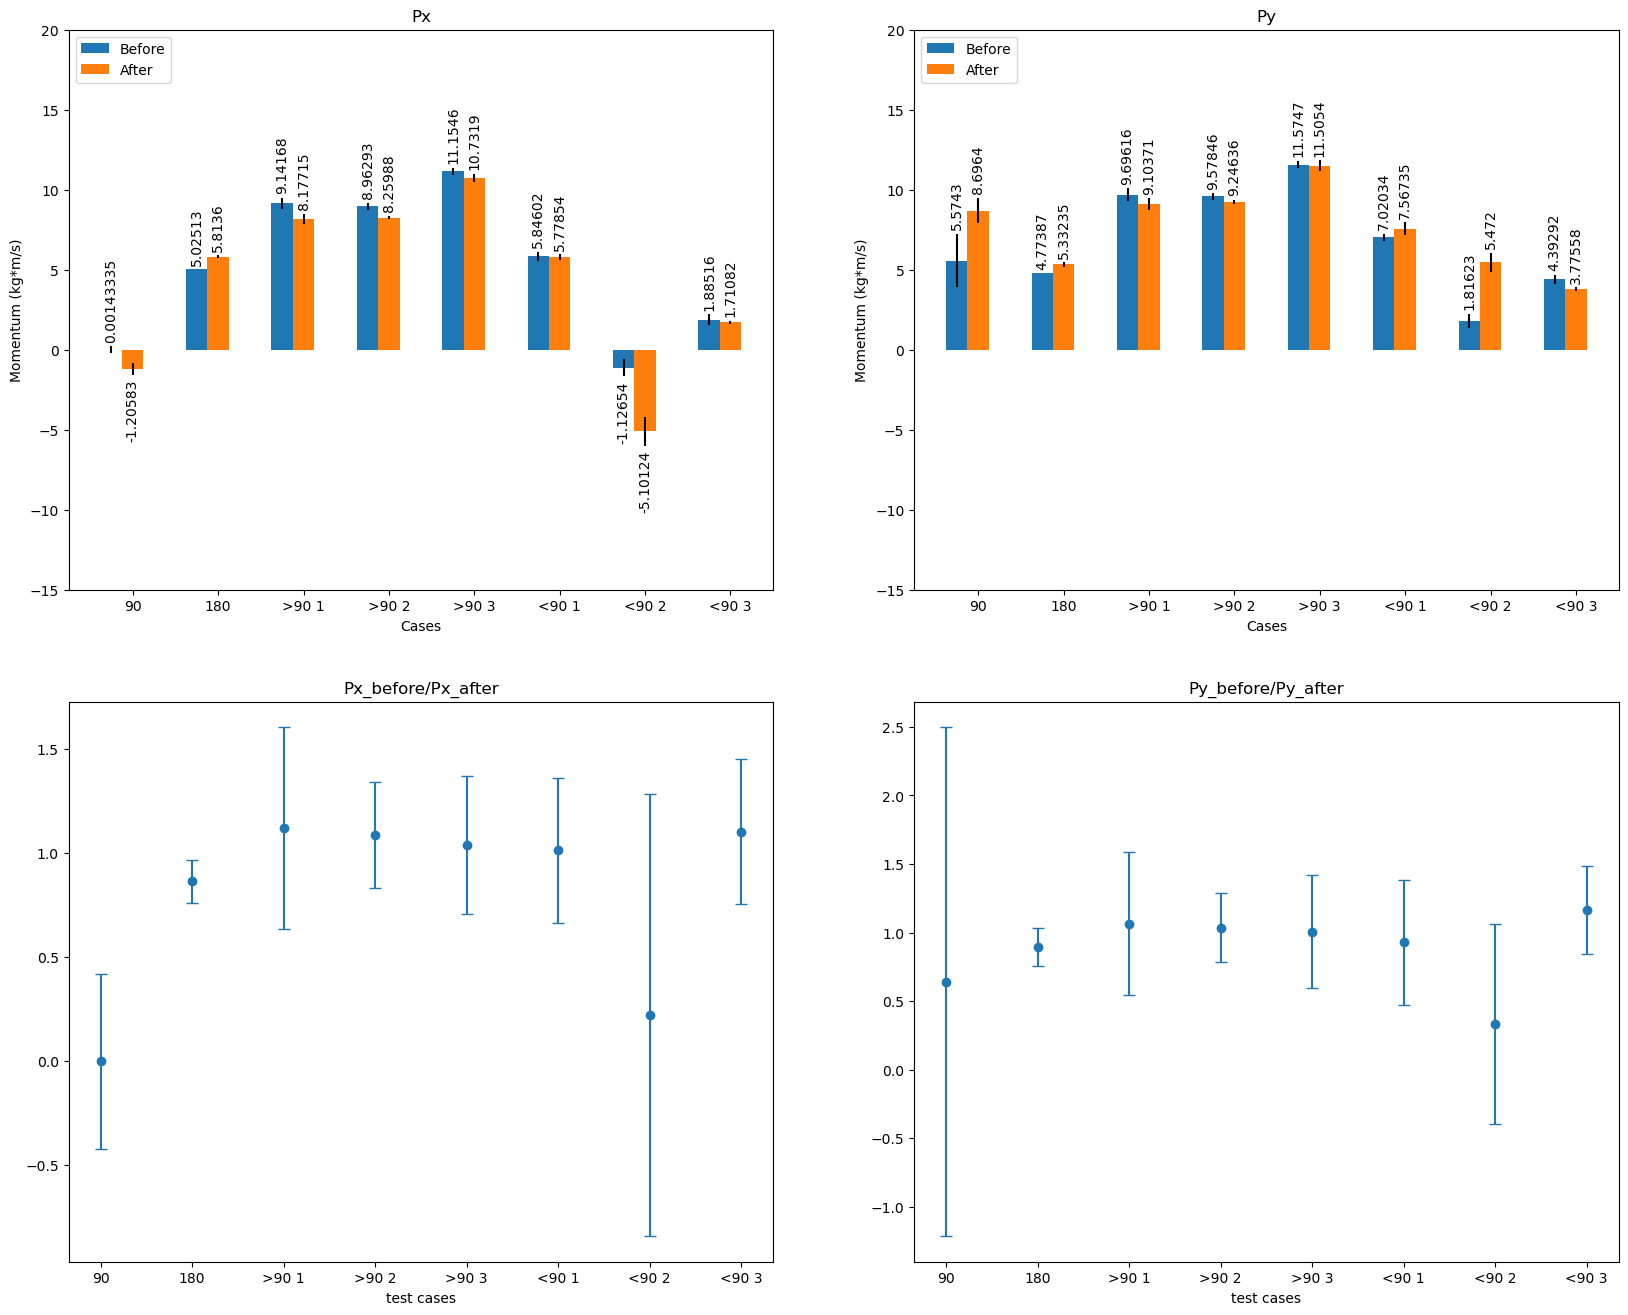

In [337]:
bars = {
    'Before': ([x["totalBeforePX"] for x in result], [x["totalBeforePXUncert"] for x in result]),
    'After': ([x["totalAfterPX"] for x in result], [x["totalAfterPXUncert"] for x in result])
}

x = np.arange(len(CASE_NAMES))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

for attribute, measurement in bars.items():
    val, uncert = measurement
    offset = width * multiplier
    rects = ax1.bar(x + offset, val, width, yerr=uncert, label=attribute)
    ax1.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Momentum (kg*m/s)')
ax1.set_xlabel('Cases')
ax1.set_title('Px')
ax1.set_xticks(x + width, CASE_NAMES)
ax1.legend(loc='upper left')
ax1.set_ylim(-15, 20)


bars = {
    'Before': ([x["totalBeforePY"] for x in result], [x["totalBeforePYUncert"] for x in result]),
    'After': ([x["totalAfterPY"] for x in result], [x["totalAfterPYUncert"] for x in result])
}

x = np.arange(len(CASE_NAMES))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

for attribute, measurement in bars.items():
    val, uncert = measurement
    offset = width * multiplier
    rects = ax2.bar(x + offset, val, width, yerr=uncert, label=attribute)
    ax2.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Momentum (kg*m/s)')
ax2.set_xlabel('Cases')
ax2.set_title('Py')
ax2.set_xticks(x + width, CASE_NAMES)
ax2.legend(loc='upper left')
ax2.set_ylim(-15, 20)

ax3.scatter(x=np.arange(len(CASE_NAMES)), y=[x["beforeOverAfterX"] for x in result])
ax3.errorbar(x=np.arange(len(CASE_NAMES)), 
        y=[x["beforeOverAfterX"] for x in result], 
        yerr=[x["beforeOverAfterXUncert"] for x in result], 
        capsize=4,
        ls="none") 
ax3.set_title("Px_before/Px_after")
ax3.set_xlabel("test cases")
ax3.set_xticks(np.arange(len(CASE_NAMES)), labels=CASE_NAMES)

ax4.scatter(x=np.arange(len(CASE_NAMES)), y=[x["beforeOverAfterY"] for x in result])
ax4.errorbar(x=np.arange(len(CASE_NAMES)), 
        y=[x["beforeOverAfterY"] for x in result], 
        yerr=[x["beforeOverAfterYUncert"] for x in result], 
        capsize=4,
        ls="none") 

ax4.set_title("Py_before/Py_after")        
ax4.set_xlabel("test cases")
ax4.set_xticks(np.arange(len(CASE_NAMES)), labels=CASE_NAMES)    

()

(0.0, 15.0)

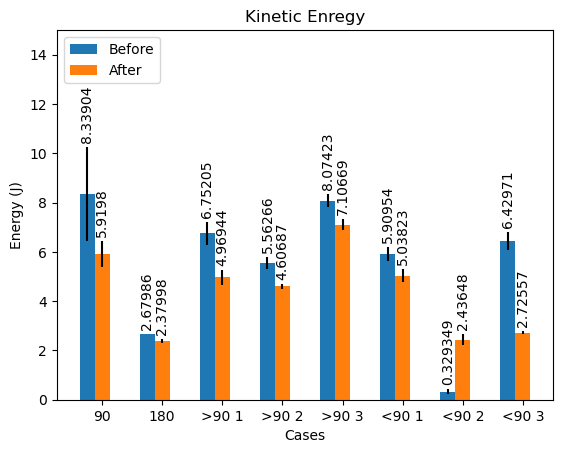

In [329]:
bars = {
    'Before': ([x["beforeTotalK"] for x in result], [x["beforeTotalKUncert"] for x in result]),
    'After': ([x["afterTotalK"] for x in result], [x["afterTotalKUncert"] for x in result])
}

x = np.arange(len(CASE_NAMES))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax1 = plt.subplots()

for attribute, measurement in bars.items():
    val, uncert = measurement
    offset = width * multiplier
    rects = ax1.bar(x + offset, val, width, yerr=uncert, label=attribute)
    ax1.bar_label(rects, padding=3, rotation=90)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Energy (J)')
ax1.set_xlabel('Cases')
ax1.set_title('Kinetic Enregy')
ax1.set_xticks(x + width, CASE_NAMES)
ax1.legend(loc='upper left')
ax1.set_ylim(0, 15)

And following is the CSV export of momentum, kinetic energy, and angles that were used to plot the above graphs

In [330]:
pandas.DataFrame(result)

,beforeAngle,afterAngle,beforePinkPX,beforePinkPXUncert,beforePinkPY,beforePinkPYUncert,beforeOrangePX,beforeOrangePXUncert,beforeOrangePY,beforeOrangePYUncert,...,beforeOrangeK,beforeOrangeKUncert,afterPinkK,afterPinkKUncert,afterOrangeK,afterOrangeKUncert,beforeTotalK,beforeTotalKUncert,afterTotalK,afterTotalKUncert
0,176.966183,112.282332,-0.618251,0.002027,-5.719541,0.128043,0.619685,0.220612,11.293837,1.676380,...,6.682630,1.906947,4.521563,0.473121,1.398236,0.216823,8.339039,1.908358,5.919799,0.520438
1,96.009006,71.616948,-0.502513,0.000000,4.773869,0.000000,5.527638,0.000000,0.000000,0.000000,...,1.527739,0.000000,1.094833,0.045076,1.285147,0.065210,2.679857,0.000000,2.379980,0.079273
2,70.145359,56.339868,8.338725,0.360907,2.057909,0.082491,0.802951,0.081691,7.638248,0.376554,...,3.008765,0.332845,3.033287,0.227686,1.936153,0.185119,6.752055,0.478557,4.969440,0.293445
3,55.922881,47.197427,7.293490,0.220086,2.715710,0.109085,1.669436,0.077625,6.862755,0.182951,...,2.510020,0.138360,1.965952,0.058092,2.640922,0.088643,5.562658,0.238211,4.606874,0.105982
4,52.446298,35.694890,8.680129,0.202665,3.306440,0.090055,2.474460,0.039490,8.268222,0.198458,...,3.740701,0.169337,4.797500,0.215788,2.309192,0.071190,8.074233,0.263621,7.106692,0.227228
5,106.899413,111.586478,-2.343759,0.105826,6.673853,0.230444,8.189779,0.268001,0.346484,0.040990,...,3.385353,0.228658,0.088344,0.028071,4.949888,0.270794,5.909535,0.292821,5.038232,0.272245
6,0.966555,30.774036,-0.851316,0.286638,1.345671,0.227830,-0.275223,0.451727,0.470555,0.362153,...,0.148943,0.092123,1.767664,0.076166,0.668815,0.215296,0.329349,0.114055,2.436479,0.228371
7,145.682795,139.272950,-5.341300,0.200550,6.520437,0.262410,7.226465,0.271333,-2.127520,0.132053,...,2.855619,0.227202,0.778217,0.034030,1.947348,0.055042,6.429713,0.364642,2.725565,0.064712


# Conclusion
Almost all experiment had very similar momentum before and after the collision, most of their momentum before to momentum after ratio being at 0 to 1.2. Test case 1 and 7 seem to be erronously captured and gave incorrect tracking position values. From video tracking, it appears that tracking script was mistaking my hand for light-orange disk. But for other, properly measured trackings, momentum after always decreased and that is to be expected as there exists other forces action on disks like air resistance and friction. From this experiment, we can conclude that momentum will be conserved under ideal condition without any friction nor air resistance. 

Kinetic energy expirement presents similar result as to the momentum. All cases, except case 7, consistently lost small portion of their original kinetic energy, which can be explained with air resistance and friction. Considering this, we also conclude that kinetic energy as well is conserved in a collision under ideal condition without any friction nor air resistance. 